# Network Observability
This example creates a simple feedforward PyTorch model with a linear output functions and randomized weights (not trained for a specific purpose). Then, it uses random sets of inputs to construct an observability matrix given measurements from specified neurons (output or hidden layer neurons). Then the Fisher information + inverse is computed and used to assess the observability of each network weight/bias. The network is visualized such that the measured neurons are indicated and the connections are colored by their observability level.

In [486]:
%reset -f
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchsummary import summary

from pybounds import EmpiricalObservabilityMatrix, FisherObservability
from network_simulator import NetworkSimulator, FCNNVisualizer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Test pytorch GPU

In [487]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: NVIDIA GeForce RTX 2080 Ti


# Define network

In [488]:
# Define a simple feedforward neural network with 8 inputs and 2 outputs
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        # Three layers with no bias terms
        self.fc1 = nn.Linear(8, 6, bias=False)
        self.fc2 = nn.Linear(6, 4, bias=False)
        self.fc3 = nn.Linear(4, 2, bias=False)

    def forward(self, x):
        # ReLu activations for input & hidden layers
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [489]:
# Create the neural network
model = SimpleNN().to(device)

In [490]:
# Get a summary of the model
summary(model, (8,))  # Input size: 8 features

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 6]              48
            Linear-2                    [-1, 4]              24
            Linear-3                    [-1, 2]               8
Total params: 80
Trainable params: 80
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


# Define simulator object for observability analysis

In [491]:
simulator = NetworkSimulator(model, device=device, output_mode='full')

In [492]:
layer_sizes = simulator.layer_sizes
print('layer sizes:', layer_sizes)

layer sizes: (8, 6, 4, 2)


## Set network weights

In [493]:
# Randomly set weights for this example
np.random.seed(seed=5)
network_weights = np.random.normal(loc=0.0, scale=1.0, size=simulator.initial_weights_numpy.shape)
simulator.set_weights(network_weights)

## Set inputs to use

In [494]:
n_sample = 100  # number of input sequences to use, should be at least > then number of network parameters for observability
u = torch.rand((n_sample, simulator.param_shapes[0][1])).to(device)
u_cpu = u.cpu().data.numpy()

## Set what neurons to measure

In [495]:
simulator.output_mask[0:-3] = 0  # set all but the last 3 neurons off (only measure the last 3 neurons)
simulator.output_mask

array([False, False, False, False, False, False, False, False, False,
        True,  True,  True])


# Simulate the network with given weights & inputs

In [496]:
y = simulator.simulate(x0=network_weights, u=u_cpu)
print('Neurons measured:', simulator.measurement_names)

Neurons measured: ['fc2_neuron_4', 'fc3_neuron_1', 'fc3_neuron_2']


In [497]:
print('Network measurements over time:')
simulator.y

Network measurements over time:


,fc2_neuron_4,fc3_neuron_1,fc3_neuron_2
0,-0.251423,-0.925747,-0.464205
1,-4.841188,-0.511287,-0.241731
2,-6.955221,3.478578,1.673840
3,3.808929,-7.223259,-1.827358
4,0.757757,-1.474620,-0.392877
...,...,...,...
95,-1.532021,-0.580113,-0.268714
96,0.390944,-1.606795,-0.604848
97,1.610787,-4.060500,-1.248841
98,0.864540,-2.213435,-0.686411


# Construct observability matrix

In [498]:
EOM = EmpiricalObservabilityMatrix(simulator, x0=network_weights, u=u_cpu, eps=1e-5, parallel=False)

In [499]:
O = EOM.O_df
O

fc1_weight_0  fc1_weight_1  fc1_weight_2  \
sensor       time_step                                             
fc2_neuron_4 0              0.149012      0.220537      0.768900   
fc3_neuron_1 0              0.092387      0.137091      0.491738   
fc3_neuron_2 0              0.047684      0.071526      0.244379   
fc2_neuron_4 1              0.357628      1.072884      0.357628   
fc3_neuron_1 1             -0.101328     -0.330806     -0.107288   
...                              ...           ...           ...   
             98            -0.405312     -1.323223     -0.739098   
fc3_neuron_2 98            -0.050664     -0.160933     -0.092387   
fc2_neuron_4 99             0.464916      0.846386      0.250340   
fc3_neuron_1 99            -0.548363     -1.001358     -0.309944   
fc3_neuron_2 99            -0.065565     -0.125170     -0.035763   

                        fc1_weight_3  fc1_weight_4  fc1_weight_5  \
sensor       time_step                                             
fc2_neuron_4 0              0.089407      0.280142      0.530481   
fc3_neuron_1 0              0.059605      0.178814      0.342727   
fc3_neuron_2 0              0.029802      0.086427      0.169873   
fc2_neuron_4 1              0.977516      0.309944      0.214577   
fc3_neuron_1 1             -0.306964     -0.098348     -0.071526   
...                              ...           ...           ...   
             98            -1.323223     -0.298023     -1.287460   
fc3_neuron_2 98            -0.160933     -0.035763     -0.157952   
fc2_neuron_4 99             0.631809      1.156330      0.357628   
fc3_neuron_1 99            -0.762939     -1.358986     -0.429153   
fc3_neuron_2 99            -0.095367     -0.166893     -0.053644   

                        fc1_weight_6  fc1_weight_7  fc1_weight_8  \
sensor       time_step                                             
fc2_neuron_4 0              0.154972      1.192093           0.0   
fc3_neuron_1 0              0.098348      0.756979           0.0   
fc3_neuron_2 0              0.050664      0.379980           0.0   
fc2_neuron_4 1              0.071526      0.619888           0.0   
fc3_neuron_1 1             -0.026822     -0.187755           0.0   
...                              ...           ...           ...   
             98            -0.834465     -0.739098           0.0   
fc3_neuron_2 98            -0.104308     -0.089407           0.0   
fc2_neuron_4 99             1.037121      0.125170           0.0   
fc3_neuron_1 99            -1.215935     -0.143051           0.0   
fc3_neuron_2 99            -0.154972     -0.017881           0.0   

                        fc1_weight_9  ...  fc2_weight_22  fc2_weight_23  \
sensor       time_step                ...                                 
fc2_neuron_4 0                   0.0  ...       2.145767       1.239777   
fc3_neuron_1 0                   0.0  ...       0.000000       0.000000   
fc3_neuron_2 0                   0.0  ...       0.000000       0.000000   
fc2_neuron_4 1                   0.0  ...       1.215935       0.452995   
fc3_neuron_1 1                   0.0  ...       0.000000       0.000000   
...                              ...  ...            ...            ...   
             98                  0.0  ...      -2.944469      -2.813339   
fc3_neuron_2 98                  0.0  ...      -0.515580      -0.491738   
fc2_neuron_4 99                  0.0  ...       0.727177       1.448393   
fc3_neuron_1 99                  0.0  ...      -1.001358      -2.026558   
fc3_neuron_2 99                  0.0  ...      -0.178814      -0.351667   

                        fc3_weight_0  fc3_weight_1  fc3_weight_2  \
sensor       time_step                                             
fc2_neuron_4 0              0.000000      0.000000      0.000000   
fc3_neuron_1 0              0.000000      0.658631      0.554323   
fc3_neuron_2 0              0.000000      0.000000      0.000000   
fc2_neuron_4 1              0.000000      0.000000   

# Compute the Fisher information & min. error covariance of each network parameter

In [509]:
FO = FisherObservability(O, R=0.1, lam=1e-8)  # R is the noise level for the measurement of each neuron, lambda is the upper bound on the error variance. See pybounds: https://github.com/vanbreugel-lab/pybounds
F, F_inv, R = FO.get_fisher_information()

In [510]:
MEV = pd.DataFrame(np.diag(F_inv), index=F_inv.columns)
error_variance = MEV.values.squeeze()
MEV

,0
fc1_weight_0,0.530518
fc1_weight_1,0.602850
fc1_weight_2,5.127462
fc1_weight_3,1.877975
fc1_weight_4,0.362183
...,...
fc3_weight_3,0.005158
fc3_weight_4,349710.019730
fc3_weight_5,0.387842
fc3_weight_6,22.035357


# Plot min. error variance of each network weight

In [511]:
vmin = 1e-4
vmax = 1e10
cnorm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)
cmap = mpl.colormaps['seismic_r']

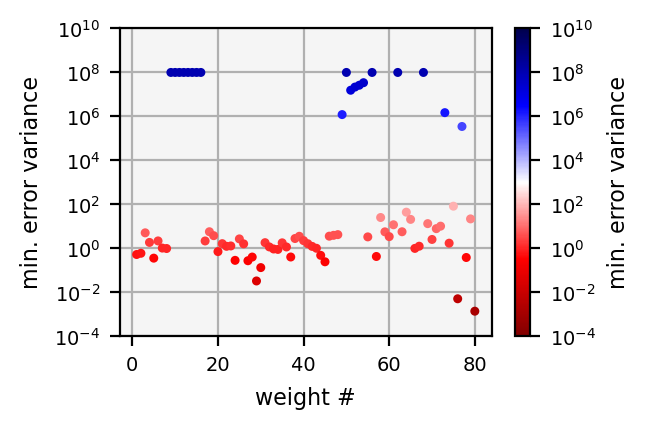

In [512]:
fig, ax = plt.subplots(figsize=(3, 2), dpi=200)
scatter = ax.scatter(np.arange(1, error_variance.shape[0] + 1), error_variance, c=error_variance,
                     s=5, norm=cnorm, cmap=cmap, zorder=2)
ax.set_yscale('log')
ax.set_ylim(vmin, vmax)
ax.set_xlabel('weight #', fontsize=8)
ax.set_ylabel('min. error variance', fontsize=8)
ax.tick_params(axis='both', which='major', labelsize=7)
ax.grid(zorder=0)
ax.set_facecolor('whitesmoke')

cbar = plt.colorbar(scatter)
cbar.set_label('min. error variance', fontsize=8)
cbar.ax.tick_params(labelsize=7)

# Visualize network 

In [513]:
# Set connection colors equal to the error variance associated with each weight
connection_colors = error_variance.copy()

In [514]:
# Set neuron colors
input_color = 0.0 * np.ones(simulator.layer_sizes[0]) # make mask of all 0's for input layer
hidden_output_color = 0.5*simulator.output_mask.astype(float) + 0.5 # make unmeasured neurons 0.5 & measured 1.0
neuron_colors = np.hstack((input_color, hidden_output_color)) # stack values

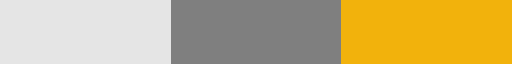

In [515]:
# Set colors of neurons
cmap_neuron = np.array([[0.9, 0.9, 0.9], # input layer neurons
                        [0.5, 0.5, 0.5],  # hidden & output layer unmeasured neurons
                        [0.95, 0.7, 0.05]]) # hidden & output layer measured neurons
cmap_neuron = mpl.colors.ListedColormap(cmap_neuron)
cmap_neuron

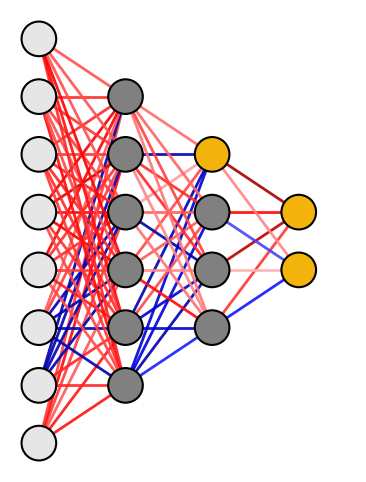

In [516]:
# Create network visualizer & draw
network = FCNNVisualizer(layer_sizes)

# Set colors
network.set_colors(name='connection', values=connection_colors, colormap=cmap, norm=cnorm)
network.set_colors(name='neuron', values=neuron_colors, colormap=cmap_neuron, norm=None)

# Draw
network.draw()

# More info on network visualization

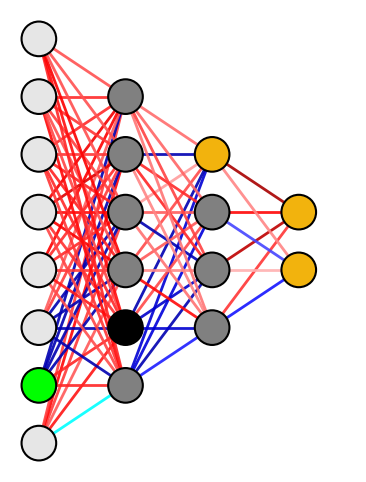

In [517]:
# Can also set colors by changing the properties directly
network.neuron_colors[1] = (0.0, 1.0, 0.0, 1.0)
network.neuron_colors[9] = (0.0, 0.0, 0.0, 1.0)
network.connection_colors[0] = (0.0, 1.0, 1.0, 1.0)
network.draw()